In [29]:
# carregar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn import preprocessing
import statsmodels.api as sm

In [30]:
"""
papel1	papel2	coint
47	RCSL4	POMO4	0.001390
46	RCSL4	MYPK3	0.012926
42	RCSL4	BRAP4	0.017312
44	RCSL4	FESA4	0.018196
29	MYPK3	CIEL3	0.019373
43	RCSL4	CIEL3	0.020951
48	RCSL4	VALE3	0.023324
45	RCSL4	GBIO33	0.026801
40	POMO4	RCSL4	0.036639
10	CIEL3	MYPK3	0.038056
"""

'\npapel1\tpapel2\tcoint\n47\tRCSL4\tPOMO4\t0.001390\n46\tRCSL4\tMYPK3\t0.012926\n42\tRCSL4\tBRAP4\t0.017312\n44\tRCSL4\tFESA4\t0.018196\n29\tMYPK3\tCIEL3\t0.019373\n43\tRCSL4\tCIEL3\t0.020951\n48\tRCSL4\tVALE3\t0.023324\n45\tRCSL4\tGBIO33\t0.026801\n40\tPOMO4\tRCSL4\t0.036639\n10\tCIEL3\tMYPK3\t0.038056\n'

In [31]:
#Leitura do dataset gerado pelo notebook resultados_trimestrais.ipynb
#path = 'C:/Users/vinicius_coin/Desktop/DADOS_MESTRADO/bovesparser-master/data/RESULTSET/'
#dfbovespa = pd.read_csv(path+"dataset_unificado.csv", sep = ';',encoding="ISO-8859-1")
path = 'C:/Users/Micro/Desktop/PAIRS_TRADING/DATA/PREBASE/'
dfbovespa = pd.read_csv(path+"COTACOES_consolidado.csv", sep = ';',encoding="ISO-8859-1")

In [1]:
ibovespa = pd.read_csv("C:/Users/Micro/Desktop/PAIRS_TRADING/DATA/APOIO/ibovespa.csv", sep = ',',encoding="ISO-8859-1",usecols = ["Date","Close"])
ibovespa["Date"] = pd.to_datetime(ibovespa["Date"])


NameError: name 'pd' is not defined

In [33]:
#Seleção do par de ativos para análise de correlação e cointegração
acao1 = 'MYPK3'
acao2 = 'CIEL3'

In [34]:
df_acao1 = dfbovespa[dfbovespa["cod_papel"] == acao1]
df_acao2 = dfbovespa[dfbovespa["cod_papel"] == acao2]


In [35]:
#Cria um dataframe com a data como index e cada ativo como coluna (valores de fechamento das cotações para cada data)
df_comp = pd.DataFrame()
df_comp['data_pregao'] =  pd.to_datetime(df_acao1['data_pregao'].values)
df_comp[acao1] =  df_acao1['preco_ultimo'].values
df_comp[acao2] =  df_acao2['preco_ultimo'].values
df_comp = pd.merge(df_comp, ibovespa, how = 'left', left_on='data_pregao', right_on='Date')
df_comp = df_comp.rename(columns={"Close": "ibovespa"})
df_comp = df_comp.drop(['Date'], axis=1)
df_comp.set_index('data_pregao', inplace=True)
df_comp_bkp = df_comp.copy()
df_comp.head()

,MYPK3,CIEL3,ibovespa
data_pregao,,,
2010-01-04,25.75,15.80,NaN
2010-01-05,26.21,15.69,NaN
2010-01-06,27.65,15.65,NaN
2010-01-07,28.37,16.02,NaN
2010-01-08,28.65,15.82,NaN


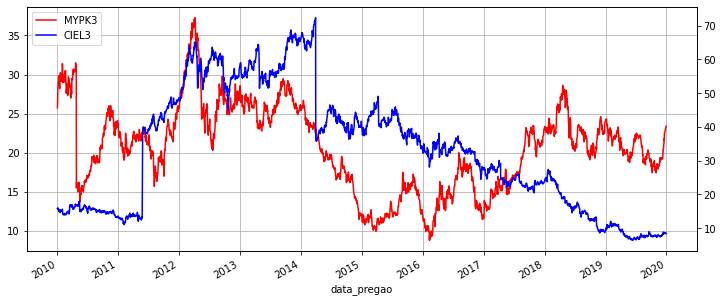

In [36]:
#Imprime um gráfico comparando o preço de cotação dos dois ativos (eixo duplo com escalas diferentes)
plt.figure(figsize=(12,5))
ax1 = df_comp[acao1].plot(color='red', grid=True, label=acao1)
ax2 = df_comp[acao2].plot(color='blue', grid=True, secondary_y=True, label=acao2)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

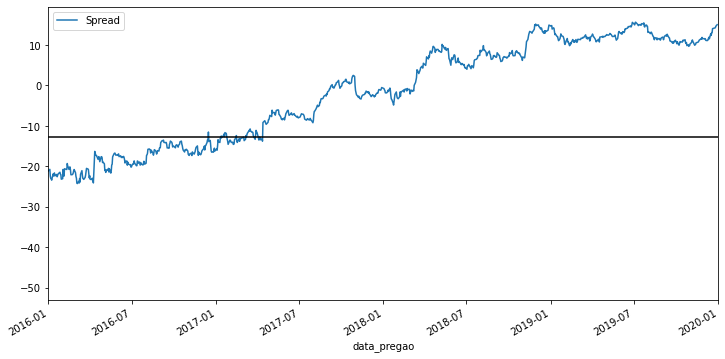

In [37]:
S1 = sm.add_constant(df_comp[acao1])
results = sm.OLS(df_comp[acao2], df_comp[acao1]).fit()
S1 = df_comp[acao1]
b = results.params[acao1]

#spread = df_comp[acao2] - b * S1
spread = df_comp[acao1] - df_comp[acao2]
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2016-01-01', '2020-01-01')
plt.legend(['Spread']);



In [ ]:
### Tentar forecast
from simpleELM import ELMRegressor

elm = ELMRegressor(n_hidden_units=100)
elm.fit(train_x, train_y)

prediction = elm.predict(test_x)

In [38]:
# Normaliza as séries para comparação
"""
def normalize_series(data):
    # take tail to drop head NA
    #return data.pct_change()
    return preprocessing.normalize(data)
"""
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))*20
    return dataNorm

df_comp = normalize(df_comp)
"""
df_comp[acao1] = normalize_series(df_comp[acao1])
df_comp[acao2] = normalize_series(df_comp[acao2])
df_comp['ibovespa'] = normalize_series(df_comp['ibovespa'])
"""
# remove os NAs da primeira linha
#df_comp = df_comp.tail(len(df_comp)-1)

df_comp.head()

,MYPK3,CIEL3,ibovespa
data_pregao,,,
2010-01-04,11.915641,2.852374,NaN
2010-01-05,12.239016,2.818996,NaN
2010-01-06,13.251318,2.806858,NaN
2010-01-07,13.757469,2.919132,NaN
2010-01-08,13.954306,2.858443,NaN


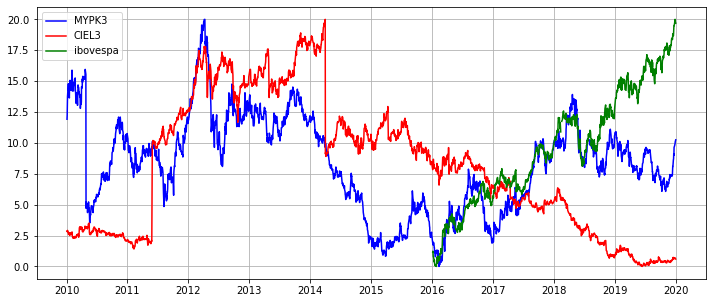

In [39]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df_comp[acao1], color='blue', label=acao1)
plt.plot(df_comp[acao2], color='red', label=acao2)
plt.plot(df_comp['ibovespa'], color='green', label='ibovespa')

ax.grid(True)

plt.legend(loc=2)
plt.show()

In [40]:
from statsmodels.tsa.stattools import coint

def corr(data1, data2):
    mean1 = data1.mean() 
    mean2 = data2.mean()
    std1 = data1.std()
    std2 = data2.std()
    corr = ((data1*data2).mean()-mean1*mean2)/(std1*std2)
    return corr

In [41]:
#df_comp = df_comp_bkp
score, pvalue, _ = coint(df_comp[acao1], df_comp[acao2]) # metodo Engle-Granger
correlation = corr(df_comp[acao1], df_comp[acao2])

print('correlacao entre %s e %s é de %f' % (acao1, acao2, correlation))
print('cointegracao entre %s e %s é de %f' % (acao1, acao2, pvalue))

correlacao entre MYPK3 e CIEL3 é de 0.227897
cointegracao entre MYPK3 e CIEL3 é de 0.178372


In [42]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(spread.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.650033
p-value: 0.457023
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Failed to Reject Ho - Time Series is Non-Stationary


In [43]:
ratio = df_comp[acao1] - df_comp[acao2]

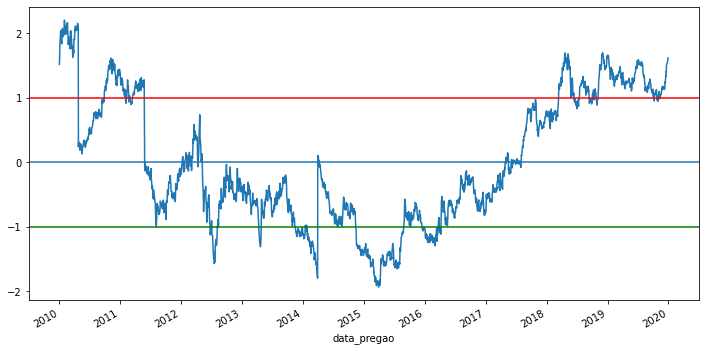

In [44]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

In [45]:
ratios = df_comp[acao1] / df_comp[acao2] 
print(len(ratios) * .80 )

1977.6000000000001


In [46]:
train = ratios[:2119]
test = ratios[2119:]


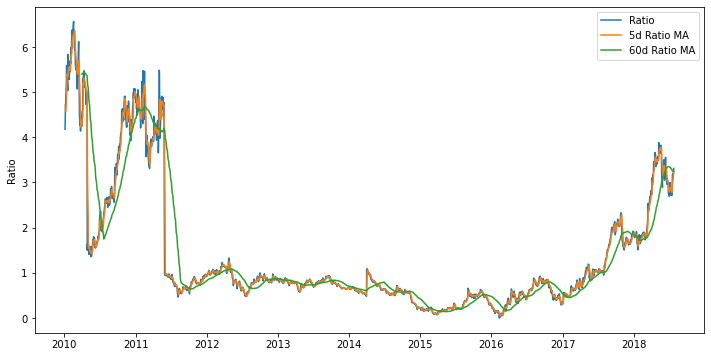

In [47]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

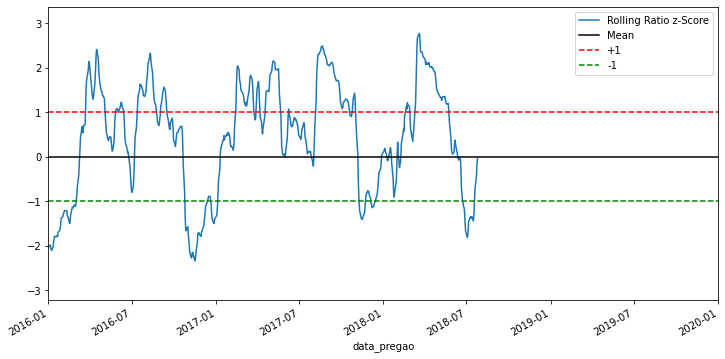

In [48]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2016-01-01', '2020-01-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

In [49]:
print(ratios.min())
print(float(ratios.max()))
print(ratios.mean()-1)
print(ratios.mean()+1)
ratios.isnull()

0.0
inf
inf
inf


data_pregao
2010-01-04    False
2010-01-05    False
2010-01-06    False
2010-01-07    False
2010-01-08    False
              ...  
2019-12-20    False
2019-12-23    False
2019-12-26    False
2019-12-27    False
2019-12-30    False
Length: 2472, dtype: bool

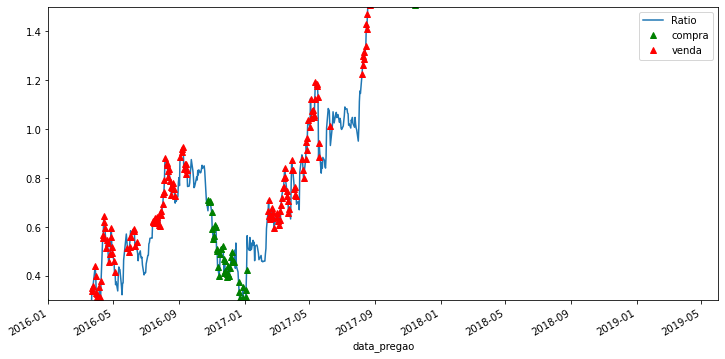

In [50]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0.3, 1.5))
plt.xlim('2016-01-01','2019-06-01')
plt.legend(['Ratio', 'compra', 'venda'])
plt.show()

In [51]:
"""
plt.figure(figsize=(12,7))

S1 = df_comp[acao1].iloc[394:]
S2 = df_comp[acao2].iloc[394:]


S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
#plt.xlim('2013-03-22', '2016-07-04')

plt.legend([acao1, acao2, 'Buy Signal', 'Sell Signal'])
plt.show()
"""

"\nplt.figure(figsize=(12,7))\n\nS1 = df_comp[acao1].iloc[394:]\nS2 = df_comp[acao2].iloc[394:]\n\n\nS1[60:].plot(color='b')\nS2[60:].plot(color='c')\nbuyR = 0*S1.copy()\nsellR = 0*S1.copy()\n\n# When you buy the ratio, you buy stock S1 and sell S2\nbuyR[buy!=0] = S1[buy!=0]\nsellR[buy!=0] = S2[buy!=0]\n\n# When you sell the ratio, you sell stock S1 and buy S2\nbuyR[sell!=0] = S2[sell!=0]\nsellR[sell!=0] = S1[sell!=0]\n\nbuyR[60:].plot(color='g', linestyle='None', marker='^')\nsellR[60:].plot(color='r', linestyle='None', marker='^')\nx1, x2, y1, y2 = plt.axis()\nplt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))\nplt.ylim(25, 105)\n#plt.xlim('2013-03-22', '2016-07-04')\n\nplt.legend([acao1, acao2, 'Buy Signal', 'Sell Signal'])\nplt.show()\n"

In [52]:
dftrade = pd.DataFrame()
lcountS1 = []
lcountS2 = []
lacao1   = []
lacao2   = []
lratios = []
lzscore = []
lmoney = []
lS1 = []
lS2 = []
laction = []

def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
       
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    #zscore = (ma1 - ma2)/std
    zscore = (ratios - ratios.mean())/ratios.std()
    
    #zscore = ratios
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        action = 'hold'
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            action = 'sell short'
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            action = 'buy long'
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            action = 'close'
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))

     
        laction.append(action)
        lS1.append(S1[i])
        lS2.append(S2[i])
        lcountS1.append(countS1)
        lcountS2.append(countS2)
        lacao1.append(S1[i])
        lacao2.append(S2[i])
        lratios.append(ratios[i])
        lzscore.append(zscore[i])
        lmoney.append(money)

    dftrade['S1'] = lS1
    dftrade['S2'] = lS2
    dftrade['countS1'] = lcountS1
    dftrade['countS2'] = lcountS2
    dftrade[acao2] = lacao2
    dftrade[acao1] = lacao1
    dftrade['ratios'] = lratios
    dftrade['zscore'] = lzscore
    dftrade['action'] = laction
    dftrade['money'] = lmoney
    return money
#data_tuples = list(zip(lcountS1,lcountS2,lacao1,lacao2,lzscore,lmoney))
#pd.DataFrame(data_tuples, columns=['Month','Day'])


In [53]:
trade(df_comp[acao1].iloc[394:], df_comp[acao2].iloc[394:], 60, 5)

0

In [54]:
dftrade.head(40)

,S1,S2,countS1,countS2,CIEL3,MYPK3,ratios,zscore,action,money
0,6.108963,11.048399,0,0,11.048399,6.108963,0.552927,NaN,hold,0
1,5.940246,11.096950,0,0,11.096950,5.940246,0.535304,NaN,hold,0
2,4.850615,10.499166,0,0,10.499166,4.850615,0.462000,NaN,hold,0
3,5.398946,10.499166,0,0,10.499166,5.398946,0.514226,NaN,hold,0
4,5.413005,10.347443,0,0,10.347443,5.413005,0.523125,NaN,hold,0
5,6.326889,10.317099,0,0,10.317099,6.326889,0.613243,NaN,hold,0
6,6.678383,10.256410,0,0,10.256410,6.678383,0.651142,NaN,hold,0
7,6.523726,10.150205,0,0,10.150205,6.523726,0.642719,NaN,hold,0
8,6.024605,9.940828,0,0,9.940828,6.024605,0.606047,NaN,hold,0
9,6.087873,9.968138,0,0,9.968138,6.087873,0.610733,NaN,hold,0


In [55]:
dftrade.to_csv(path+'/carteira.csv',encoding="ISO-8859-1",sep=";", index = False)

In [56]:
score, pvalue, _ = coint(df_comp[acao1], df_comp[acao2]) # metodo Engle-Granger
correlation = corr(df_comp[acao1], df_comp[acao2])

print('correlacao entre %s e %s é de %f' % ("resultado modelo", "ibovespa", correlation))
print('cointegracao entre %s e %s é de %f' % ("resultado modelo", "ibovespa", pvalue))

correlacao entre resultado modelo e ibovespa é de 0.227897
cointegracao entre resultado modelo e ibovespa é de 0.178372
